In [30]:
import xarray as xr
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geopandas as gpd

In [2]:
# Precipitação CHIRPS (mensal)
precip = xr.open_dataarray("dataset/netcdf_data/chirps_mensal_1981_2023.nc")


# Exemplo: xr.open_mfdataset("dataset/sst_global/sst_global_*.nc")
sst = xr.open_mfdataset("dataset/sst_global/sst_atlantico_*.nc")["analysed_sst"]
sst_mensal = sst - 273.15  # Converter de Kelvin para Celsius

In [18]:
# Calcular percentil 99 mensal para cada pixel (base climatológica mensal)
p99_mensal = precip.reduce(np.nanpercentile, q=99, dim="time")

# Média espacial do percentil 99 (mensal)
p99_series = precip.reduce(np.nanpercentile, q=99, dim=["lat","lon"])

# Série temporal do percentil 99 mensal (média espacial)
p99_mensal_series = precip.groupby("time").reduce(np.nanpercentile, q=99, dim=("lat","lon"))

# Selecionar período comum (1982-2023)
p99_mensal_series = p99_mensal_series.sortby("time")
p99_mensal_series = p99_mensal_series.sel(time=slice("1982-01-01", "2023-12-31"))

In [19]:
# Mensal -> climatologia mensal -> anomalia
sst_clim = sst_mensal.groupby("time.month").mean("time")

sst_anom = sst_mensal.groupby("time.month") - sst_clim

sst_anom_media = sst_anom.mean(dim=("latitude","longitude"))


In [20]:
sst_3m = sst_anom_media.shift(time=3)
sst_6m = sst_anom_media.shift(time=6)


In [7]:
def correlacao_spearman_series(x, y):
    # Garante alinhamento via mask
    mask = (~np.isnan(x)) & (~np.isnan(y))
    return spearmanr(x[mask], y[mask])

In [23]:

# Calcular correlações
corr_0, p_0 = correlacao_spearman_series(p99_mensal_series.values, sst_anom_media.values)
corr_3, p_3 = correlacao_spearman_series(p99_mensal_series.values, sst_3m.values)
corr_6, p_6 = correlacao_spearman_series(p99_mensal_series.values, sst_6m.values)

print(f"Sem defasagem:  ρ = {corr_0:.2f}, p = {p_0:.3f}")
print(f"Defasagem 3m:   ρ = {corr_3:.2f}, p = {p_3:.3f}")
print(f"Defasagem 6m:   ρ = {corr_6:.2f}, p = {p_6:.3f}")


Sem defasagem:  ρ = 0.01, p = 0.762
Defasagem 3m:   ρ = 0.03, p = 0.472
Defasagem 6m:   ρ = 0.08, p = 0.071


In [31]:
# --- Carregar shapefile ---
shapefile_path = "dataset/shape/caatinga_estados.shp"
gdf_estados = gpd.read_file(shapefile_path)

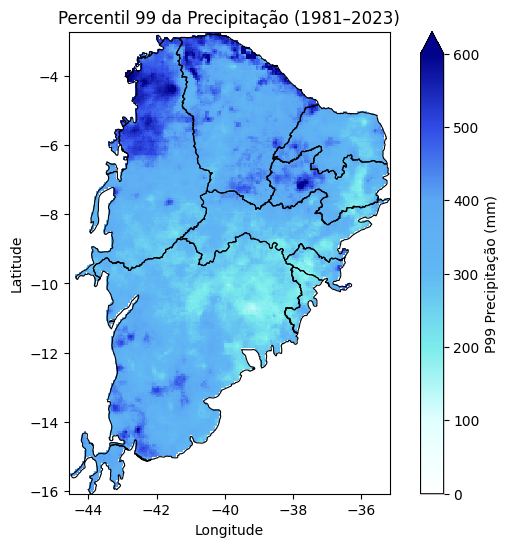

In [101]:
# Criar colormap: branco para 0 e tons de azul até 450 mm
# Definir sequência de cores desejadas
#colors = ["#FFFFFF","#E0FFFF","#00FF7F", "#4ADB4A","#50AD12","#487205",  "#014601"]
colors = ["#FFFFFF","#E0FFFF","#7BECEC", "#60B8F3", "#5CA8F3","#304BE6","#02028B"]
# springgreen->lightcyan->darkseagreen->olivedrab->limegreen->darkgreen 

# Criar colormap
cmap_custom = mcolors.LinearSegmentedColormap.from_list("white_to_darkblue", colors)

plt.figure(figsize=(8,6))
p = p99_mensal.plot(
    cmap=cmap_custom,
    vmin=0, vmax=600, 
    cbar_kwargs={
        "label": "P99 Precipitação (mm)"
        #,
        #"ticks": np.arange(0, 601) #, 50
    }
)

# Adicionar contorno dos estados (sem preenchimento)
gdf_estados.boundary.plot(ax=plt.gca(), color='black', linewidth=0.8)

plt.title("Percentil 99 da Precipitação (1981–2023)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,5))

# Plot da precipitação P99 (eixo da esquerda)
#ax1.plot(p99_common.year, p99_common, color="blue", marker="o", label="P99 Precipitação (mm)")
#ax1.set_ylabel("P99 Precipitação (mm)", color="blue")
#ax1.tick_params(axis='y', labelcolor="blue")

# Plot da SST anômala (eixo da direita)
#ax2 = ax1.twinx()
ax1.plot(sst_common.year, sst_common, color="red", marker="s", label="Anomalia SST (°C)")
ax1.set_ylabel("Anomalia SST (°C)", color="red")
ax1.tick_params(axis='y', labelcolor="red")

plt.title("Percentil 99 de Precipitação vs Anomalia de SST (Atlântico Tropical)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


In [ ]:
def mann_kendall_test(series):
    n = len(series)
    s = 0
    for k in range(n-1):
        s += np.sum(np.sign(series[k+1:] - series[k]))
    var_s = n*(n-1)*(2*n+5)/18
    if s > 0:
        z = (s-1)/np.sqrt(var_s)
    elif s < 0:
        z = (s+1)/np.sqrt(var_s)
    else:
        z = 0
    p = 2*(1-norm.cdf(abs(z)))
    return z, p

def sens_slope(series, anos):
    slopes = []
    n = len(series)
    for i in range(n-1):
        slopes.extend((series[i+1:] - series[i]) / (anos[i+1:] - anos[i]))
    return np.median(slopes)


In [ ]:
# P99
z_p99, p_p99 = mann_kendall_test(p99_common.values)
slope_p99 = sens_slope(p99_common.values, anos_comuns)

# SST
z_sst, p_sst = mann_kendall_test(sst_common.values)
slope_sst = sens_slope(sst_common.values, anos_comuns)

print(f"P99 - Z: {z_p99:.2f}, p: {p_p99:.3f}, slope: {slope_p99:.3f} mm/ano")
print(f"SST - Z: {z_sst:.2f}, p: {p_sst:.3f}, slope: {slope_sst:.3f} °C/ano")
